# How to combine Data Augmentations

This section will explain how to combine different data augmentations and create custom
augmenters to apply during the pretraining (but also during fine-tuning phase).

Different use cases with increased complexity will be presented. 

We hope this will help users understand how to use this module.

First of all, let's import the dataloading module and some other packages.

<div class="alert alert-warning">
<b>WARNING:</b> to run this notebook you will also need <b>matplotlib</b>, which is not a main dependecy of the <b>selfeeg</b> library. Be sure to install it in your environment
</div>

In [1]:
import os
import sys
import random
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))
from selfeeg import augmentation as aug

import torch
import numpy as np
import matplotlib.pyplot as plt
# set seeds for reproducibility
seed = 12
random.seed( seed )
np.random.seed( seed )
torch.manual_seed( seed )
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.figsize'] = (15.0, 6.0)

## functional submodule

The augmentation module is divided in two submodules:

1. the functional submodule, which gathers all the data augmentation functions.
2. the compose submodule, which gathers all the classes designed to call and compose the data augmentations in various ways

Note that all augmentation are compatible with pytorch tensors sent to the GPU, although some configurations may not improve the computational time as expected

<div class="alert alert-info">
<b>NOTE 1:</b> the command 
<code>from selfeeg import augmentation</code>    
will automatically import all functions and classes from the two submodules.
</div>

<div class="alert alert-info">
<b>NOTE 2:</b> most of the data augmentation functions have a `batch_equal` argument. This argument will let the user choose between an augmentation performed equally on all EEGs in the batch or not. To summarize, batch_equal set to True will make the computation faster but will reduce the varibility, while batch_equal set to False will do the opposite  
</div>

here is a simple example of an augmentation with the ``add_eeg_artifact`` function

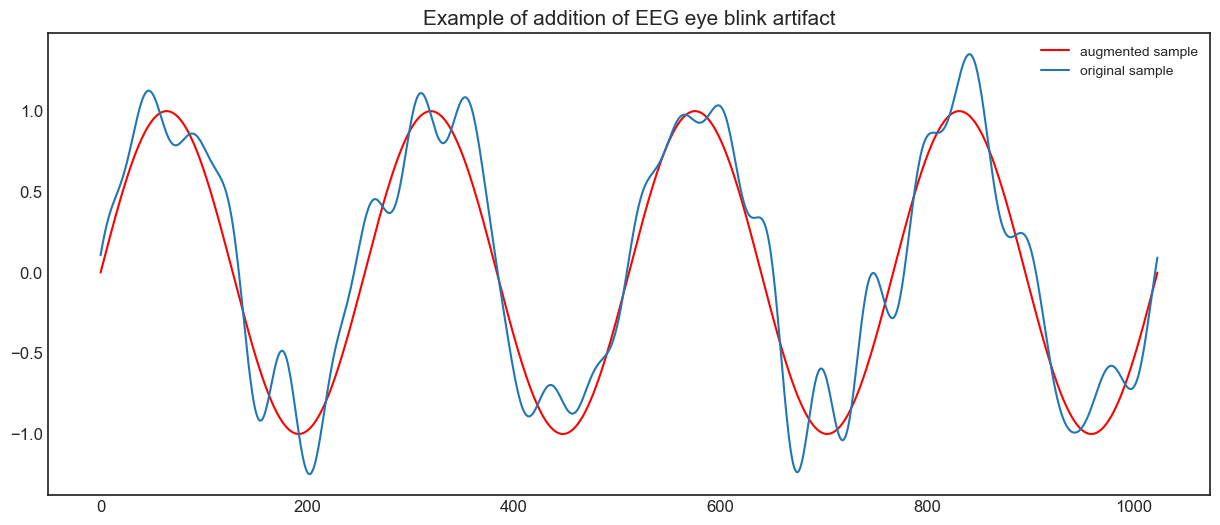

In [2]:
# create a random EEG batch, 32 channels, 1024 samples, 128 Hz
# all channels will have a sinusoid for better visualization
Fs = 128
BatchEEG = torch.zeros(16,32,1024) + torch.sin(torch.linspace(0, 8*np.pi,1024))

# simple example
BatchEEGaug = aug.add_eeg_artifact(BatchEEG, Fs, 'eye' , amplitude=0.5, batch_equal=False)

plt.plot(BatchEEG[0,0],'r')
plt.plot(BatchEEGaug[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of addition of EEG eye blink artifact', fontsize=15)
plt.legend(['augmented sample', 'original sample'])
plt.show()

## Compose submodule

With the compose submodule it is possible to combine different augmentation functions in a highly customizable way. The module allows users to:

1. Apply a specific augmentation with preset optional arguments
2. Apply a specific augmentation with random selected optional arguments from a given range
3. Apply a sequence of augmentations
4. Apply an augmentation selected at random from a given list

The combination of the previously listed functionalities allows user to construct more complex augmentation patterns, making this module valuable also for non-self-supervised learning applications.


The following cells will present various use cases to use as a reference.

## case 1: specific augmentation with preset optional arguments

Suppose one wants to call a specific augmentation every time with the same optional arguments. This can be done in two simple ways:

1. define a lambda function.
2. create an instance of the ``StaticSingleAug`` class, which has an extra functionality explained in use case 2.

Let's assume we want to call each time the ``add_egg_artifact`` use in the previous cell.

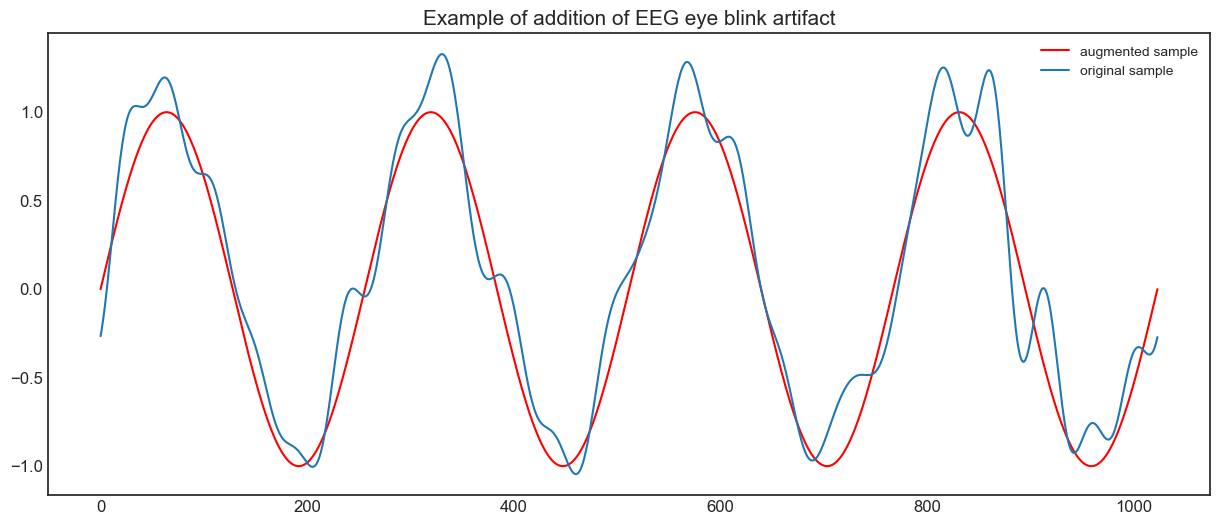

In [3]:
# simple example
Aug_eye = aug.StaticSingleAug(aug.add_eeg_artifact, 
                              {'Fs': Fs, 'artifact': 'eye', 'amplitude': 0.5, 'batch_equal': False}
                             )
BatchEEGaug = Aug_eye(BatchEEG)

plt.plot(BatchEEG[0,0],'r')
plt.plot(BatchEEGaug[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of addition of EEG eye blink artifact', fontsize=15)
plt.legend(['augmented sample', 'original sample'])
plt.show()
    

## case 2: specific augmentation with LIST of preset optional arguments

As previously stated, ``StaticSingleAug`` has an extra functionality compared to lambda functions, which is its ability to handle multiple set of optional arguments. This is important in many contrastive learning arguments, since the data augmentation is performed twice (you may want to repeat couples of augmentations to fed to each branch of the siamese network, widely used in contrastive learning approaches). 

Let's assume we want to call each time the ``add_egg_artifact`` use in the previous cell, but this time we want also that the amplitude of such an artifact will be 0.5 in one call, and 1 in the second.

To do that we just need to give all sets of optional arguments in a list.

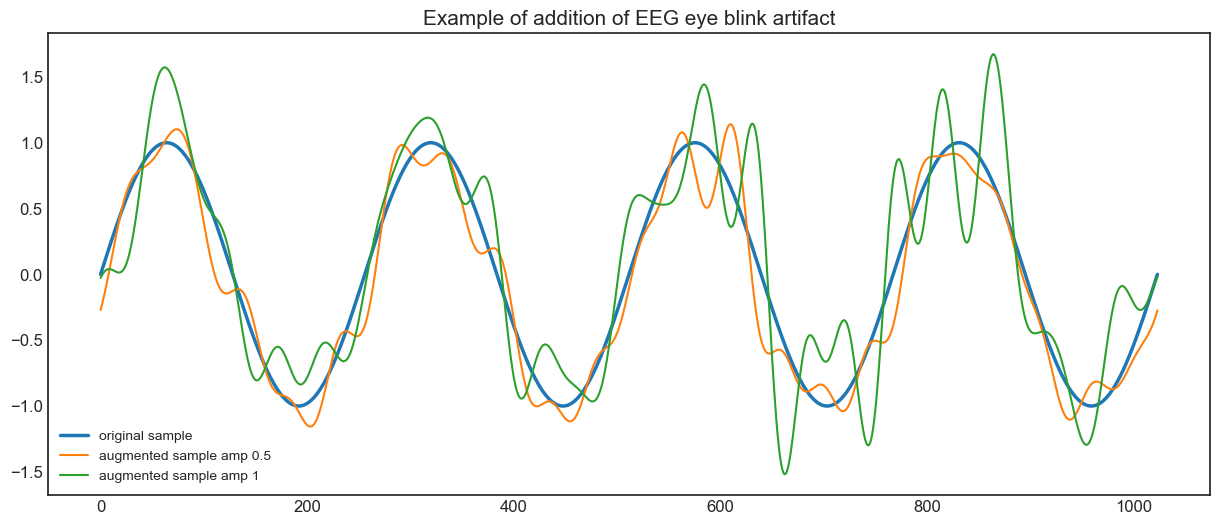

In [4]:
# simple example
Aug_eye = aug.StaticSingleAug(aug.add_eeg_artifact, 
                              [{'Fs': Fs, 'artifact': 'eye', 'amplitude': 0.5, 'batch_equal': False},
                               {'Fs': Fs, 'artifact': 'eye', 'amplitude': 1.0, 'batch_equal': False} #new set
                              ]
                             )
BatchEEGaug1 = Aug_eye(BatchEEG)
BatchEEGaug2 = Aug_eye(BatchEEG)

plt.plot(BatchEEG[0,0],linewidth=2.5)
plt.plot(BatchEEGaug1[0,0])
plt.plot(BatchEEGaug2[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of addition of EEG eye blink artifact', fontsize=15)
plt.legend(['original sample', 'augmented sample amp 0.5', 'augmented sample amp 1'])
plt.show()
    

## case 3: specific augmentation with random extracted optional arguments from range

If one wants to apply a specific augmentation where some optional arguments are selected randomly from a given range of continuous or discrete values, ``DynamicSingleAug`` is the right class to use. ``DynamicSingleAug`` requires some arguments to be set properly, but once it is initialized in the right way, it will make easier to produce augmented samples

Let's assume we want to call the ``warp_signal`` augmentation with random parameters. This function provides the most complex case one will face with the implemented augmentations, since it accepts different types of inputs (bool, float, int). Check the function help to better understand each arguments. 

<div class="alert alert-warning">
<b>WARNING:</b> the only thing you need to carefully check when instantiating a <code>DynamicSingleAug</code> is the type of the optional argument to extract. To assure compatibility with most of the operations, the class will extract only <b>integers</b> from the given range if a specific type is not given, but it is suggested to avoid resorting to such thing.
</div>

Now let's set a range of values from each argument of the augmentation.

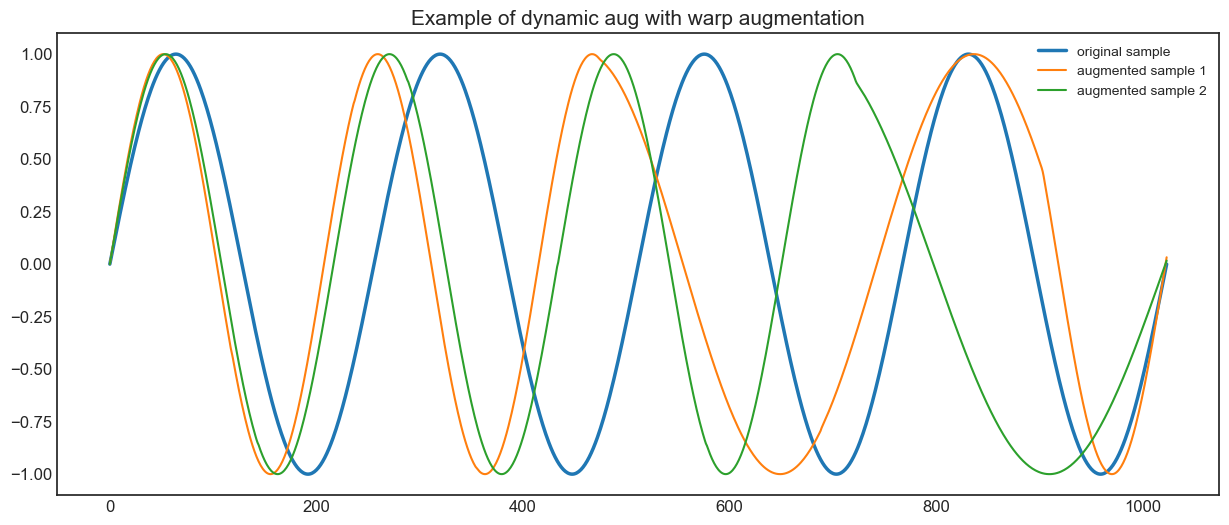

In [5]:
# simple example
Aug_warp = aug.DynamicSingleAug(aug.warp_signal, 
                               discrete_arg = {'batch_equal': [True, False]}, #discrete args accepts single values if 
                                                                               #you want those to be static
                               range_arg= {'segments': [5,15], 'stretch_strength': [1.2,1.5],
                                           'squeeze_strength': [0.7,0.85]},
                               range_type={'segments': True, 'stretch_strength': False,
                                           'squeeze_strength': False} # true = int, false = float
                             )
BatchEEGaug1 = Aug_warp(BatchEEG)
BatchEEGaug2 = Aug_warp(BatchEEG)

plt.plot(BatchEEG[0,0],linewidth=2.5)
plt.plot(BatchEEGaug1[0,0])
plt.plot(BatchEEGaug2[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of dynamic aug with warp augmentation', fontsize=15)
plt.legend(['original sample', 'augmented sample 1', 'augmented sample 2'])
plt.show()

## case 4: sequence of augmentations

If one has defined different **single augmentations** but wants to combine them in a specific order, ``SequentialAug`` is the right class to use. ``SequentialAug`` only requires to give the augmentations as multiple arguments. The input order is used as the sequence order, so be sure to not make mistakes during the initialization.

<div class="alert alert-warning">
<b>WARNING:</b> Be careful to not stack too many augmentations. Produce too different samples may have negative effects on the pretraining (and fine-tuning) phase
</div>

Now let's compose the eye blink artifact and the random warp augmentations.

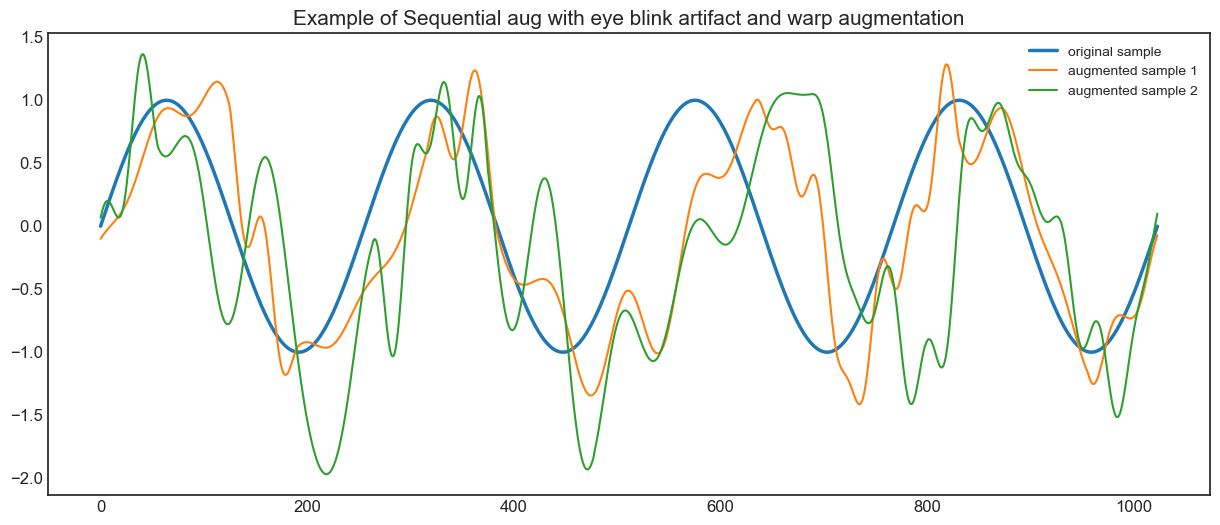

In [6]:
Sequence1= aug.SequentialAug(Aug_eye, Aug_warp)
BatchEEGaug1 = Sequence1(BatchEEG)
BatchEEGaug2 = Sequence1(BatchEEG)

plt.plot(BatchEEG[0,0],linewidth=2.5)
plt.plot(BatchEEGaug1[0,0])
plt.plot(BatchEEGaug2[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of Sequential aug with eye blink artifact and warp augmentation', fontsize=15)
plt.legend(['original sample', 'augmented sample 1', 'augmented sample 2'])
plt.show()

## case 5: Random augmentation from list

If one has defined different **single augmentations** but wants each time choose one at random (or with given probabilities), ``RandomAug`` is the right class to use. ``RandomAug`` only requires to give the augmentations as multiple arguments. It is also possible to assign a weight which will be used to set how frequently an augmentation will be chosen. Make sure to give the probabilities in the same order as the augmentations.

Now let's choose at random between the eye blink artifact and the random warp augmentation with a 70\% chance of picking the eye blinking.

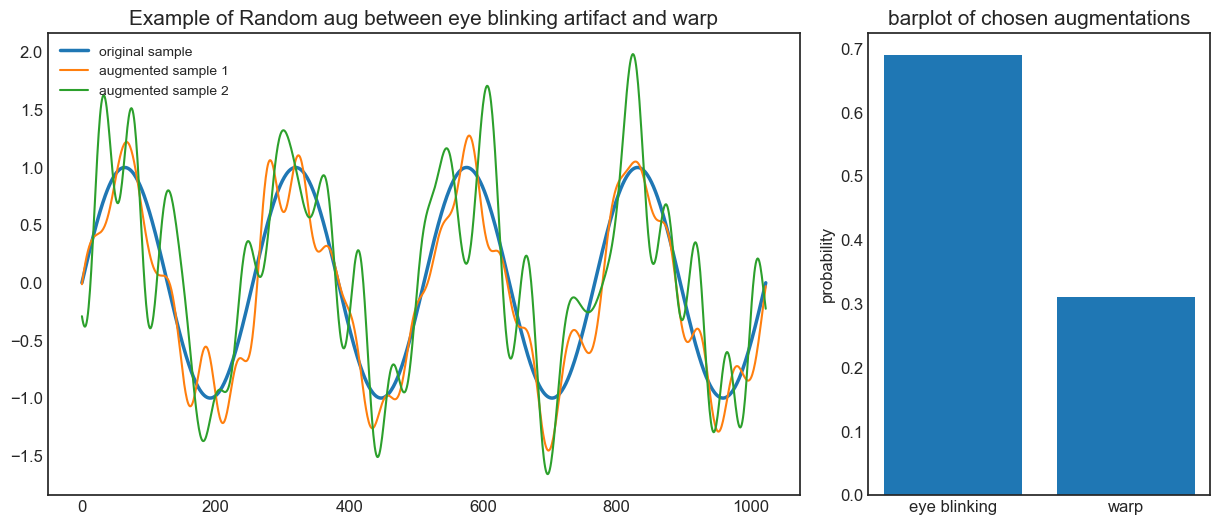

In [7]:
Sequence2= aug.RandomAug(Aug_eye, Aug_warp, p=[0.7, 0.3])
BatchEEGaug1 = Sequence2(BatchEEG)
BatchEEGaug2 = Sequence2(BatchEEG)

# simulate 10000 augmentations calls
# this line is used in RandomAug to choose the index of the list of augmentations to call
# note that we have added the size argument to make computation faster, in the class only 1 value
# is returned
idx=np.random.choice(Sequence2.nprange_, size= 1000, p=Sequence2.p)
counts=[(1000-len(np.nonzero(idx)[0]))/1000, len(np.nonzero(idx)[0])/1000]

plt.subplot(1,3,(1,2))
plt.plot(BatchEEG[0,0],linewidth=2.5)
plt.plot(BatchEEGaug1[0,0])
plt.plot(BatchEEGaug2[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of Random aug between eye blinking artifact and warp', fontsize=15)
plt.legend(['original sample', 'augmented sample 1', 'augmented sample 2'],loc='upper left')
plt.subplot(1,3,3)
plt.bar(['eye blinking', 'warp'],counts)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('barplot of chosen augmentations', fontsize=15)
plt.ylabel('probability',fontsize=12)
plt.show()

## case 6: Combine them all

The previous cases represent basic combination of augmentations. However, these classes can be further combined to produce more complex examples. Here there is a custom example. 

This augmenter is a sequential augmentation of three different blocks:

1. Random augmentation between flip horizontal, flip vartical, or identity with 50\% of probability of doing nothing
2. Random augmentation between two noise adder: the eeg artifact or the band noise 
3. Random augmentation between the warp or a crop and resize augmentation

Each augmentation in points 2 and 3 and three will be also called with random optional arguments

Let's see how this complex augmentation can be created 

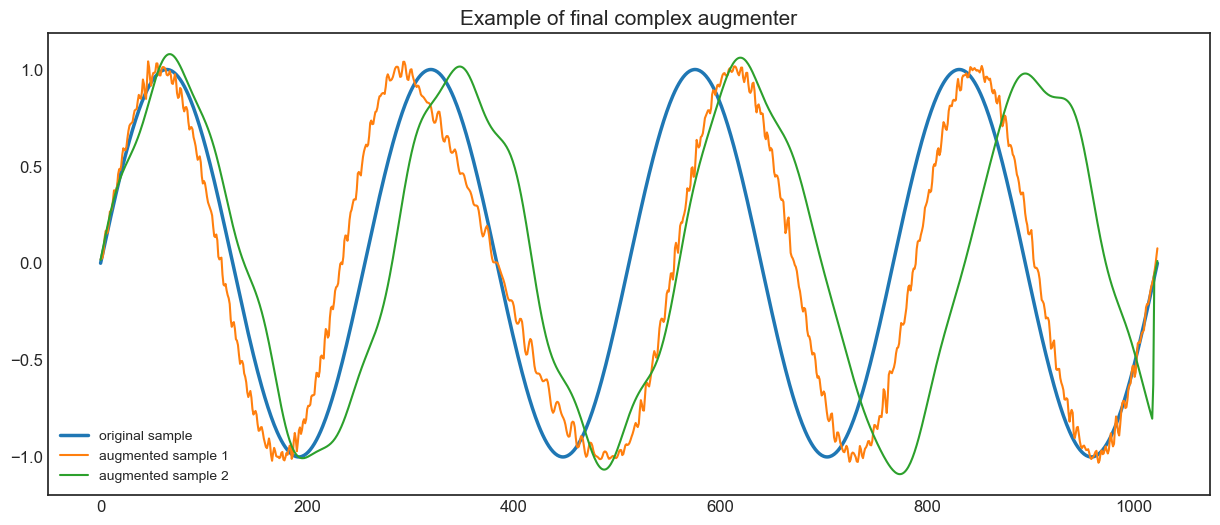

In [8]:
# DEFINE AUGMENTER
# FIRST RANDOM SELECTION: APPLY FLIP OR CHANGE REFERENCE OR NOTHING
AUG_flipv = aug.StaticSingleAug(aug.flip_vertical)
AUG_flipr = aug.StaticSingleAug(aug.flip_horizontal)
AUG_id = aug.StaticSingleAug(aug.identity)
Sequence1 = aug.RandomAug( AUG_id, AUG_flipv, AUG_id, p=[0.5, 0.25, 0.25])

# SECOND RANDOM SELECTION: ADD SOME NOISE
AUG_band = aug.DynamicSingleAug(aug.add_band_noise, 
                                 discrete_arg={'bandwidth': ["delta", "theta", "alpha", "beta", (30,49) ], 
                                               'samplerate': Fs,
                                               'noise_range': 0.1
                                              }
                                )
Aug_eye = aug.DynamicSingleAug(aug.add_eeg_artifact,
                               discrete_arg = {'Fs': Fs, 'artifact': 'eye', 'batch_equal': False},
                               range_arg= {'amplitude': [0.1,0.5]},
                               range_type={'amplitude': False}
                             )
Sequence2 = aug.RandomAug( AUG_band, Aug_eye)

# THIRD RANDOM SELECTION: CROP OR RANDOM PERMUTATION
AUG_crop = aug.DynamicSingleAug(aug.crop_and_resize,
                                discrete_arg={'batch_equal': False},
                                range_arg ={'N_cut': [1, 4], 'segments': [10,15]},
                                range_type ={'N_cut': True, 'segments': True})
Sequence3 = aug.RandomAug( AUG_crop, Aug_warp)

# FINAL AUGMENTER: SEQUENCE OF THE THREE RANDOM LISTS
Augmenter = aug.SequentialAug(Sequence1, Sequence2, Sequence3)


BatchEEGaug1 = Augmenter(BatchEEG)
BatchEEGaug2 = Augmenter(BatchEEG)

plt.plot(BatchEEG[0,0],linewidth=2.5)
plt.plot(BatchEEGaug1[0,0])
plt.plot(BatchEEGaug2[0,0])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('Example of final complex augmenter', fontsize=15)
plt.legend(['original sample', 'augmented sample 1', 'augmented sample 2'])
plt.show()